In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re

import urllib

from scipy import stats

</div>
<div class="1. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Data</h2>
        <h4>In this first section we import and rearrange the data.</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Data acquisition</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Here we load the relevant data using the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pd.read_csv()</span> method. The data we are dealing with follows a relational model. The specific navigation paths can be represented as graphs where the nodes concern the wikipedia pages that are connected through (directional) edges representing the hyperlinks.
    </span>
</div>

In [2]:
#Import relevant DataFrames

#Articles data
articles = pd.read_csv("data/articles.tsv", skiprows=11, names=["article"])
articles['article'] = articles['article'].apply(urllib.parse.unquote) #Parsing URL encoding

#Category data
categories = pd.read_csv("data/categories.tsv", sep="\t", skiprows=12, names=["article", "category"])
categories["article"] = categories["article"].apply(urllib.parse.unquote) #Parsing URL encoding

#Links data
links = pd.read_csv("data/links.tsv", sep="\t", skiprows=11, names=["article", "link"])
links["article"] = links["article"].apply(urllib.parse.unquote) #Parsing URL encoding
links["link"] = links["link"].apply(urllib.parse.unquote) #Parsing URL encoding

#Finished paths
paths_finished = pd.read_csv("data/paths_finished.tsv", sep="\t", skiprows=15, names=["hashedIpAddress",
                                                                                      "timestamp",
                                                                                      "durationInSec",
                                                                                      "path",
                                                                                      "rating"])
paths_finished["path"] = paths_finished["path"].apply(urllib.parse.unquote) #Parsing URL encoding

#Unfinished paths
paths_unfinished = pd.read_csv("data/paths_unfinished.tsv", sep="\t", skiprows=16, names=["hashedIpAddress",
                                                                                          "timestamp",
                                                                                          "durationInSec",
                                                                                          "path",
                                                                                          "target",
                                                                                          "type"])
paths_unfinished["path"] = paths_unfinished["path"].apply(urllib.parse.unquote) #Parsing URL encoding
paths_unfinished["target"] = paths_unfinished["target"].apply(urllib.parse.unquote) #Parsing URL encoding

# Add the length of the paths
paths_unfinished['pathLength'] = paths_unfinished['path'].apply(lambda x : len(str(x).split(';')))
paths_finished['pathLength'] = paths_finished['path'].apply(lambda x : len(str(x).split(';')))

#shortest path matrix
with open('data/shortest-path-distance-matrix.txt', 'r') as file:
    
    #Initialize shortest_path_distance list
    shortest_path_distance = []
    
    for line in file:
        
        #Check if the first character of the line is either a digit or underscore
        if re.search("([0-9]|_)", line[0]): 
            
            #Append list to shortest_path_distance
            shortest_path_distance.append([np.nan if x=='_' else int(x) for x in line.strip()])
    
#Convert to numpy ndarray
shortest_path_distance = np.array(shortest_path_distance)    
    


</div>
<div class="1.2 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Data concatenation</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We want to merge both the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> DataFrame. This make the analysis more convenient when comparing both types. More specifically we add the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">target</span> column to and drop the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">rating </span> column of <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>. We can then concatenate the respective DataFrames together. 
</div>

In [3]:
#Merge all the paths 
paths_finished['target'] = paths_finished['path'].apply(lambda x : str(x).split(';')[-1])

#Add and remove (ir)relevant colums.
paths_finished_ = paths_finished.copy()
paths_unfinished_ = paths_unfinished.copy()
paths_finished_['type'] = 'finished'
paths_finished_ = paths_finished_.drop('rating',axis =1)

#concatenate data
paths_all = pd.concat([paths_finished_, paths_unfinished_]) 

#print head of resulting DataFrame
paths_all.head(4)

,hashedIpAddress,timestamp,durationInSec,path,pathLength,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,9,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,4,Greece,finished


</div>
<div class="2. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>2. Article exploration</h2>
        <h4>In this section we conduct a first data exploration. We will focus on the features of the individual articles solely.</h4>
    </span>
</div>
</div>

</div>
<div class="2.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.1 Category distribution</h3>
    </span>
</div>
</div>
<div class="2.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We start by investigation the category distribution among the wikipedia articles. This way we try to see if there are some specific categories that are dominantly represented among the wikipedia articles.
    </span>
</div>

Number of articles	: 4604
Number of categories	: 129

TOP 3:
CATEGORY                                      COUNT
subject.Countries                            : 229
subject.Science.Biology.Birds                : 161
subject.Geography.Geography_of_Great_Britain : 124




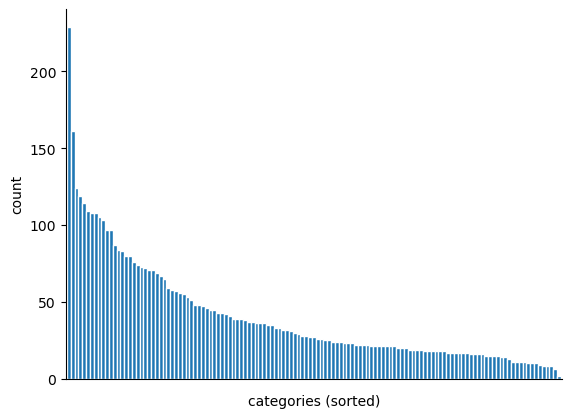

In [4]:
#Get number of articles and number of unique categories
nb_articles = len(articles)
nb_categories = len(categories['category'].unique())

#Find number of articles per category
categories_grouped = categories.groupby('category').count().add_suffix('_count')
categories_grouped = categories_grouped.sort_values('article_count', ascending=False) #Sort by count in descending order

#Print statistics
print('Number of articles\t: {}'.format(nb_articles))
print('Number of categories\t: {}\n'.format(nb_categories))
print('TOP 3:')
print("{:<45} {}".format('CATEGORY', 'COUNT'))
for index, row in categories_grouped.head(3).iterrows():
    print("{:<45}: {}".format(index, row['article_count']))
print("\n")

#Plot category distrubution (sorted)
g = categories_grouped.plot(y='article_count', kind='bar', legend=False, width=1, edgecolor=(1,1,1))
g.set(ylabel='count')
g.set(xlabel='categories (sorted)')
g.set(xticklabels=[]);
g.tick_params(bottom=False);
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)


</div>
<div class="2.2 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.2 Link distribution</h3>
    </span>
</div>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Now we will look at the distribution of the number of links per article. Here we aim to measure the degree of the nodes (i.e. the number of outgoing edges for every article). Finding articles with a high degree could potentially identify so-called <em>"get away to hubs"</em> as described in <a href="http://infolab.stanford.edu/~west1/pubs/West-Pineau-Precup_IJCAI-09.pdf">Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts</a>.
    </span>
</div>

Number of links	: 119882

TOP 3:
ARTICLE                                       COUNT
United_States                                : 294
Driving_on_the_left_or_right                 : 255
List_of_countries                            : 244




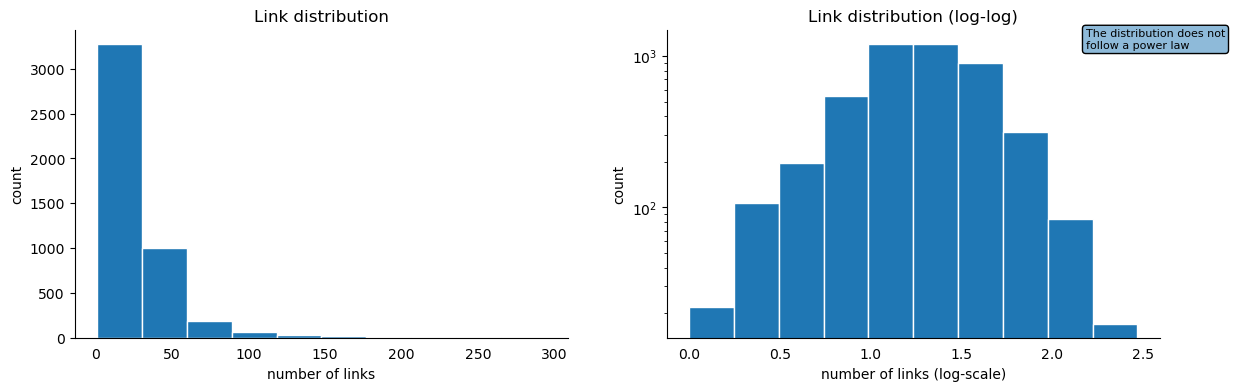

In [5]:
#Get total number of links
nb_links = len(links)

#Get the number of links per article
links_grouped = links.groupby('article').count().add_suffix('_count')
links_grouped = links_grouped.sort_values('link_count', ascending=False) #Sort by count in descending order

#Print statistics
print('Number of links\t: {}\n'.format(nb_links))

print('TOP 3:')
print("{:<45} {}".format('ARTICLE', 'COUNT'))
for index, row in links_grouped.head(3).iterrows():
    print("{:<45}: {}".format(index, row['link_count']))
print("\n")

    
#Plot category distrubution (sorted)
fig, ax = plt.subplots(1,2, figsize=(14,4));
ax = ax.ravel()

g1 = links_grouped.plot(y='link_count', kind='hist', legend=False, edgecolor=(1,1,1), ax=ax[0])
g1.set(title="Link distribution")
g1.set(ylabel='count')
g1.set(xlabel='number of links')
g1.tick_params(bottom=False);
g1.spines['right'].set_visible(False)
g1.spines['top'].set_visible(False)

g2 = np.log10(links_grouped['link_count']).plot(kind='hist', legend=False, edgecolor=(1,1,1), ax=ax[1], log=True)
g2.set(title="Link distribution (log-log)")
g2.set(ylabel='count')
g2.set(xlabel='number of links (log-scale)')
g2.tick_params(bottom=False);
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
ax[1].text(0.85, 0.94, s='The distribution does not\nfollow a power law', fontsize=8, transform=ax[1].transAxes, bbox=dict(boxstyle='round', facecolor=(31/255, 119/255, 180/255, 0.5), edgecolor='k'));


</div>
<div class="2.3 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.3 Shortest distance matrix</h3>
    </span>
</div>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Quick visualization of the short distance matrix. Vertical orange lines represent target articles that cannot be reached by any other source article. Horizontal orange lines represent source articles that have connection with any other article (i.e. it has no hyperlink).
    </span>
</div>

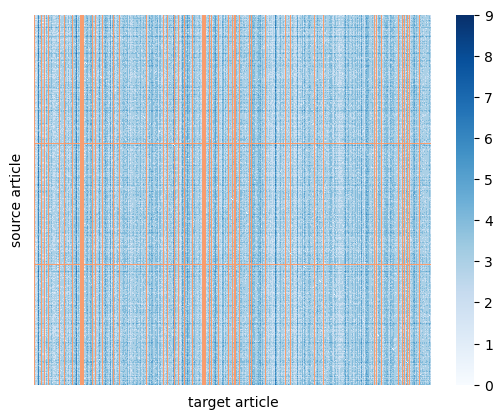

In [6]:
g = sns.heatmap(shortest_path_distance, xticklabels=False, yticklabels=False, linewidths=0, cmap='Blues');
g.set_facecolor('#f79d6f');
g.set(ylabel='source article');
g.set(xlabel='target article');

</div>
<div class="3. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>3. Navigation paths</h2>
        <h4>We will now start to dig more into the navigation paths</h4>
    </span>
</div>
</div>

</div>
<div class="3.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.1 Duration of navigation paths</h3>
    </span>
</div>
</div>
</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We will investigate the differences of the time between <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> (differentiation between timeout and restart) and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>.
    </span>
</div>

In [7]:
#Bootstrap function
def bootstrap_CI(data, nbr_draws, with_means = False):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    if with_means :
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)], means
    else : 
        return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]
    

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Split <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> in <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">restart</span>  
    </span>
</div>

In [8]:
#split the unfinished paths in timeout and restart
unfinished_timeout = paths_unfinished[paths_unfinished['type'] == 'timeout']
unfinished_restart = paths_unfinished[paths_unfinished['type'] == 'restart']
print('number of unfinished paths (timeout)\t: {}'.format(len(unfinished_timeout)))
print('number of unfinished paths (restart)\t: {}'.format(len(unfinished_restart)))
print('TOTAL\t\t\t\t\t: {}'.format(len(paths_unfinished)))

number of unfinished paths (timeout)	: 9323
number of unfinished paths (restart)	: 15552
TOTAL					: 24875


</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Now visualize the distrubution of time spent using boxplots and histograms. It seems like finished path has a longer tail (maybe these users show more perserverance, why would that be?)
    </span>
</div>

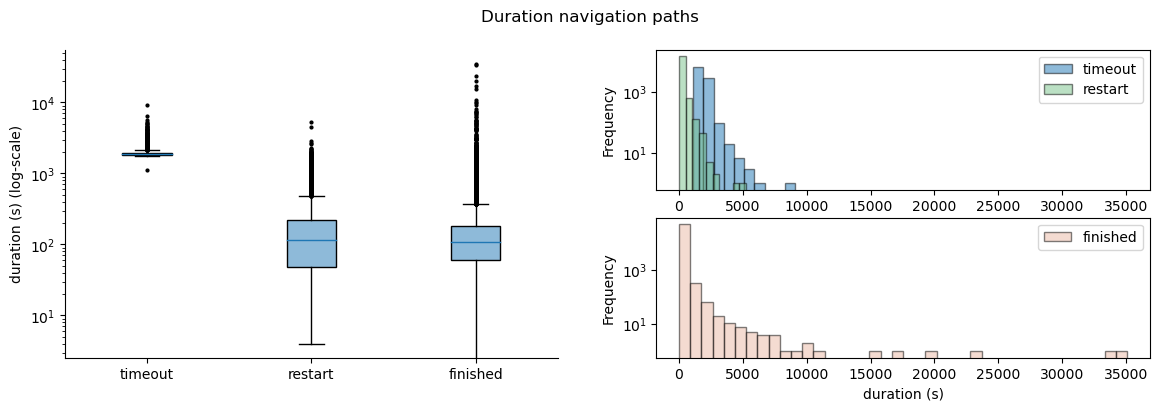

In [9]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Duration navigation paths')
ax = plt.subplot(1,2,1)
flierprops = {'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'}
boxprops= {'facecolor': (31/255, 119/255, 180/255, 0.5), 'color': 'k'}
medianprops = {'color': (31/255, 119/255, 180/255)}
ax.boxplot([unfinished_timeout['durationInSec'], unfinished_restart['durationInSec'], paths_finished['durationInSec']], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['timeout', 'restart', 'finished']);
ax.set_yscale('log')
ax.set_ylabel('duration (s) (log-scale)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2,2,4)
paths_finished.plot(y='durationInSec', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), bins=40, ax=ax, log=True, color=(235/255, 184/255, 164/255, 0.5), label="finished")
ax.legend();
ax.set_xlabel('duration (s)')
xlim = ax.get_xlim();

ax = plt.subplot(2,2,2)
unfinished_timeout.plot(y='durationInSec', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(31/255, 119/255, 180/255, 0.5), label="timeout")
unfinished_restart.plot(y='durationInSec', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(120/255, 194/255, 139/255, 0.5), label="restart")
ax.legend();
ax.set_xlim(xlim);

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Let's zoom in now on the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span>. We hypothesize that a player's idle period is included in the time that is spend. Hence we want to remove this from our data. As we are only interesting in activate attempts, we want to cut outliers and subtract the potential idle period for <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span>. In the code below we first get rid of the outliers.
    </span>
</div>

In [10]:
# Cutting outliers
range_outlier = 1.5
Q1 = unfinished_timeout['durationInSec'].quantile(0.25)
Q3 = unfinished_timeout['durationInSec'].quantile(0.75)
IQR = Q3 - Q1
lower_value = unfinished_timeout['durationInSec'].median() - IQR*range_outlier
upper_value = unfinished_timeout['durationInSec'].median() + IQR*range_outlier


unfinished_timeout_cut = unfinished_timeout[unfinished_timeout['durationInSec']>=lower_value]
unfinished_timeout_cut = unfinished_timeout_cut[unfinished_timeout_cut['durationInSec']<=upper_value]


</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We can make a guess of the duration of the idle period by substracting the minimum duration of the unfinished paths that resulted in <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span>.
    </span>
</div>

In [11]:
#change values of timeout by the minimum timestamp
unfinished_timeout_cut['durationInSec'] = unfinished_timeout_cut['durationInSec']-unfinished_timeout_cut['durationInSec'].min()

In [12]:
colors = [('black', 'gray'), ('blue', 'cornflowerblue'), ('red', 'lightcoral'), ('darkorange', 'bisque'), ('lawngreen','palegreen'), ('cyan','paleturquoise'), ('violet', 'thistle')]
ci_finished, stats_finished = bootstrap_CI(paths_finished['durationInSec'], 10000, True)
ci_notfiniti, stats_notfiniti = bootstrap_CI(unfinished_timeout_cut['durationInSec'], 10000, True)
ci_notfinires, stats_notfinires = bootstrap_CI(unfinished_restart['durationInSec'], 10000, True)


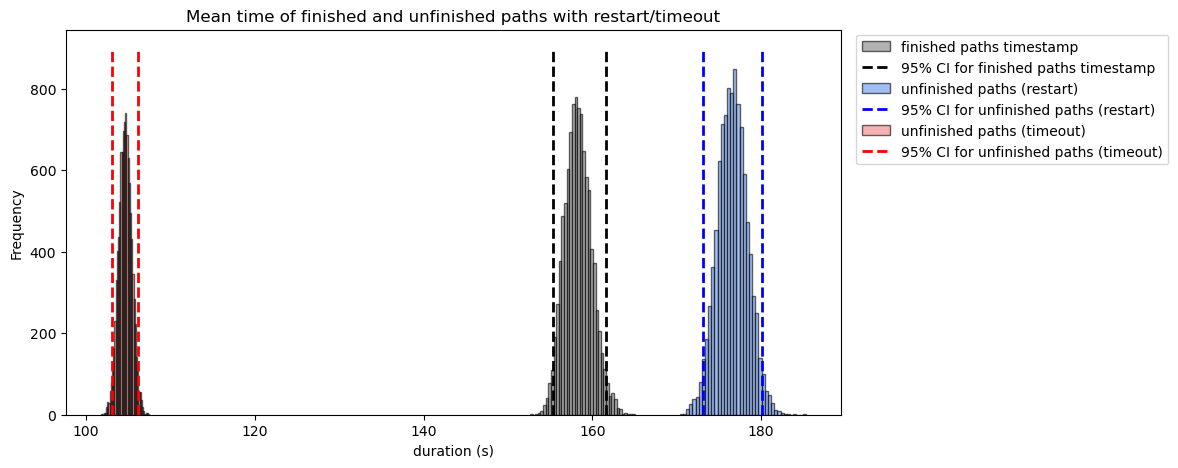

In [13]:
plt.figure(figsize=(10,5))
plt.hist(stats_finished, bins=40, edgecolor = 'k', color=colors[0][1],alpha = 0.6, label = 'finished paths timestamp')
plt.vlines(ci_finished, 0,900, ls='--', color=colors[0][0], linewidth=2, label = '95% CI for finished paths timestamp')
plt.hist(stats_notfinires, bins=40, edgecolor = 'k', color=colors[1][1],alpha = 0.6, label = 'unfinished paths (restart)')
plt.vlines(ci_notfinires, 0,900, ls='--', color=colors[1][0], linewidth=2, label = '95% CI for unfinished paths (restart)')
plt.hist(stats_notfiniti, bins=40, edgecolor = 'k', color=colors[2][1],alpha = 0.6, label = 'unfinished paths (timeout)')
plt.vlines(ci_notfiniti, 0,900, ls='--', color=colors[2][0], linewidth=2, label = '95% CI for unfinished paths (timeout)')
plt.title('Mean time of finished and unfinished paths with restart/timeout')
plt.xlabel('duration (s)')
plt.ylabel('Frequency')
plt.legend(loc=(1.02, 0.65));

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We observe that the means are (significantly) different. However, looking at the median values (see boxplots) we do not observe the same trend. Maybe the mean is not a valid metric, especially since the distributions seem to be relatively heavy tailed. Maybe a log-log plot could improve on this.
    </span>
</div>

</div>
<div class="3.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.2 Length of navigation paths</h3>
    </span>
</div>
</div>
</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We will investigate the differences of the length between <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> (differentiation between timeout and restart) and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>.
    </span>
</div>

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Similar approach to visualizing the time of the navigation paths. However now focusing on path length. Most striking observation is that <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> has a longer tail than <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">restart</span>
    </span>
</div>

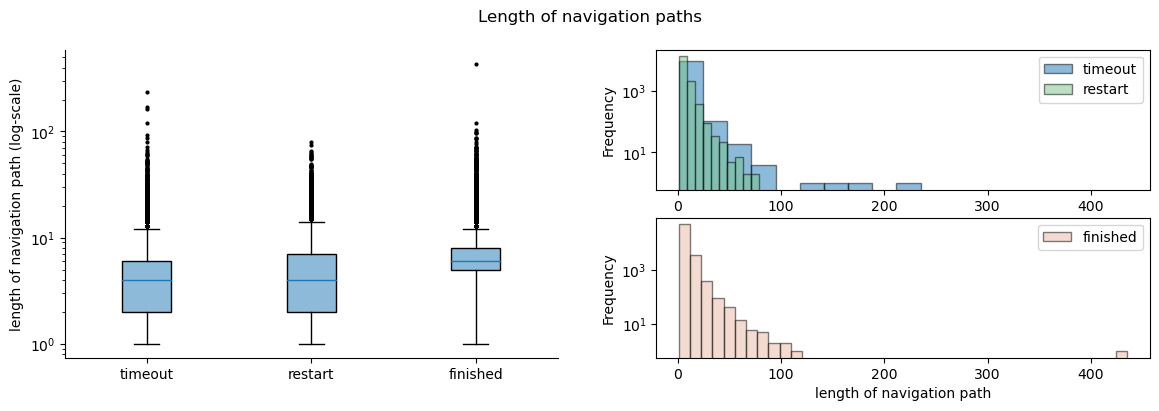

In [14]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Length of navigation paths')
ax = plt.subplot(1,2,1)
flierprops = {'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'}
boxprops= {'facecolor': (31/255, 119/255, 180/255, 0.5), 'color': 'k'}
medianprops = {'color': (31/255, 119/255, 180/255)}
ax.boxplot([unfinished_timeout['pathLength'], unfinished_restart['pathLength'], paths_finished['pathLength']], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['timeout', 'restart', 'finished']);
ax.set_yscale('log')
ax.set_ylabel('length of navigation path (log-scale)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2,2,4)
paths_finished.plot(y='pathLength', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), bins=40, ax=ax, log=True, color=(235/255, 184/255, 164/255, 0.5), label="finished")
ax.legend();
ax.set_xlabel('length of navigation path')
xlim = ax.get_xlim();

ax = plt.subplot(2,2,2)
unfinished_timeout.plot(y='pathLength', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(31/255, 119/255, 180/255, 0.5), label="timeout")
unfinished_restart.plot(y='pathLength', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(120/255, 194/255, 139/255, 0.5), label="restart")
ax.legend();
ax.set_xlim(xlim);

</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We will now conduct a bootstrap algorithm to find the (mean) differences of the pathlength between <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>
    </span>
</div>

In [15]:
ci_finished, stats_finished = bootstrap_CI(paths_finished['pathLength'], 10000, True)
ci_notfiniti, stats_notfiniti = bootstrap_CI(unfinished_timeout['pathLength'], 10000, True)
ci_notfinires, stats_notfinires = bootstrap_CI(unfinished_restart['pathLength'], 10000, True)

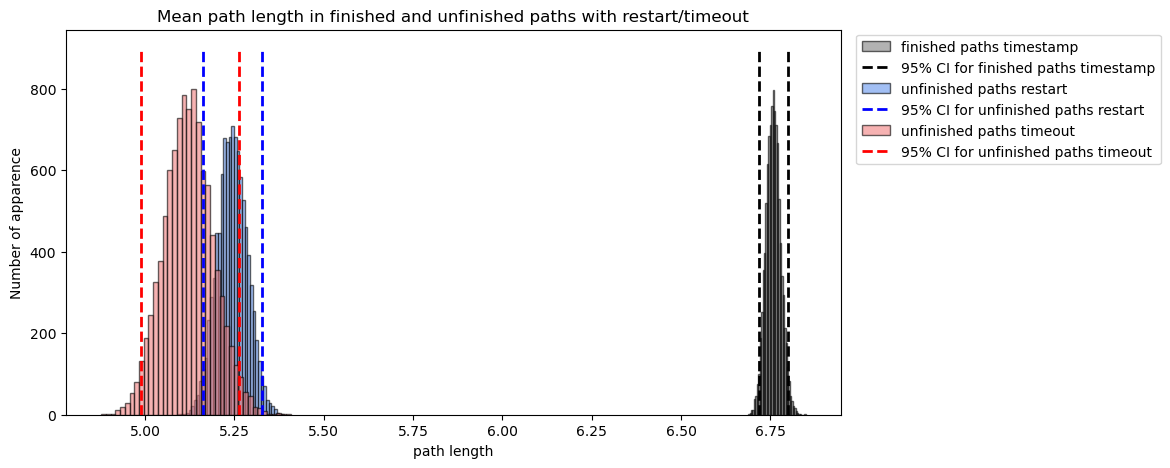

In [16]:
colors = [('black', 'gray'), ('blue', 'cornflowerblue'), ('red', 'lightcoral'), ('darkorange', 'bisque'), ('lawngreen','palegreen'), ('cyan','paleturquoise'), ('violet', 'thistle')]

plt.figure(figsize=(10,5))
plt.hist(stats_finished, bins=40, edgecolor = 'k', color=colors[0][1],alpha = 0.6, label = 'finished paths timestamp')
plt.vlines(ci_finished, 0,900, ls='--', color=colors[0][0], linewidth=2, label = '95% CI for finished paths timestamp')
plt.hist(stats_notfinires, bins=40, edgecolor = 'k', color=colors[1][1],alpha = 0.6, label = 'unfinished paths restart')
plt.vlines(ci_notfinires, 0,900, ls='--', color=colors[1][0], linewidth=2, label = '95% CI for unfinished paths restart')
plt.hist(stats_notfiniti, bins=40, edgecolor = 'k', color=colors[2][1],alpha = 0.6, label = 'unfinished paths timeout')
plt.vlines(ci_notfiniti, 0,900, ls='--', color=colors[2][0], linewidth=2, label = '95% CI for unfinished paths timeout')
plt.title('Mean path length in finished and unfinished paths with restart/timeout')
plt.xlabel('path length')
plt.ylabel('Number of apparence')
plt.legend(loc=(1.02, 0.65));

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Similar to the duration, we again observe that the means are (significantly) different. And looking at the median values (see boxplots) we do not observe the same trend. Perhaps same argument holds here concerning heavy-tailed distribution.
    </span>
</div>

</div>
<div class="3.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.3 Regression</h3>
    </span>
</div>
</div>
</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Here we will investigate if we can do a (logistic) regression to predict <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span> vs <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> based on the variables <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">durationInSec</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> only. The same will be conducted for <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> vs <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">restart.</span>
    </span>
</div>

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
    Let's first see if we can find correlations between time spent and path length. Intuitively it should be positively correlated. We find that the correlations are not too convincing (especially for finished paths). This is partly because many relatively small paths take for some reason relatively long (perhaps a player was stuck for a long period of time).
    </span>
</div>

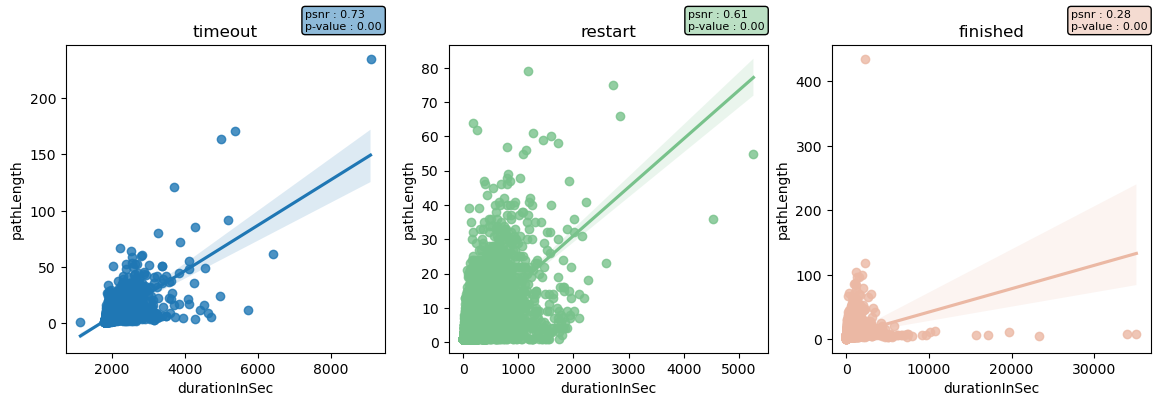

In [17]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax = ax.ravel()

st, p = stats.pearsonr(unfinished_timeout['durationInSec'], unfinished_timeout['pathLength'])
sns.regplot(x='durationInSec',y='pathLength', data=unfinished_timeout, ax=ax[0], color=(31/255, 119/255, 180/255, 0.5)).set(title='timeout');
ax[0].text(0.75, 1.05, s='psnr : {:.2f}\np-value : {:.2f}'.format(st, p), fontsize=8, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor=(31/255, 119/255, 180/255, 0.5), edgecolor='k'));

st, p = stats.pearsonr(unfinished_restart['durationInSec'], unfinished_restart['pathLength'])
sns.regplot(x='durationInSec',y='pathLength', data=unfinished_restart, ax=ax[1], color=(120/255, 194/255, 139/255, 0.5)).set(title='restart');
ax[1].text(0.75, 1.05, s='psnr : {:.2f}\np-value : {:.2f}'.format(st, p), fontsize=8, transform=ax[1].transAxes, bbox=dict(boxstyle='round', facecolor=(120/255, 194/255, 139/255, 0.5), edgecolor='k'));

st, p = stats.pearsonr(paths_finished['durationInSec'], paths_finished['pathLength'])
sns.regplot(x='durationInSec',y='pathLength', data=paths_finished, ax=ax[2], color=(235/255, 184/255, 164/255, 0.5)).set(title='finished');
ax[2].text(0.75, 1.05, s='psnr : {:.2f}\np-value : {:.2f}'.format(st, p), fontsize=8, transform=ax[2].transAxes, bbox=dict(boxstyle='round', facecolor=(235/255, 184/255, 164/255, 0.5), edgecolor='k'));


</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Simple logistic regression to predict if the player give up or will restart by only <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">durationInSec</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> into account.
    </span>
</div>

In [18]:
#import of lybraries
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
#prepare the data
reg_unfinished_tim = unfinished_timeout.copy()
reg_unfinished_res = unfinished_restart.copy()
reg_unfinished_tim['y'] = 1
reg_unfinished_res['y'] = 0
regression_data = pd.concat([reg_unfinished_tim,reg_unfinished_res])
regression_data_X = regression_data[['pathLength','durationInSec']]
regression_data_y = regression_data[['y']]

In [20]:
"""#standardization of the values:
means = np.mean(regression_data_X,axis = 0)
stds = np.std(regression_data_X,axis = 0)
regression_data_X = (regression_data_X - means)/stds
regression_data_X['y']= regression_data_y
df_all = regression_data_X """

#log-transform of values:
regression_data_X = np.log(regression_data_X)
regression_data_X['y']= regression_data_y
regression_data_X.replace([np.inf, -np.inf], np.nan, inplace=True)
regression_data_X.dropna(axis=1)
df_all = regression_data_X

In [21]:
formula2 = 'y ~ pathLength + durationInSec'
mod = smf.logit(formula=formula2, data=df_all)
np.random.seed(2)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.011692
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                24875
Model:                          Logit   Df Residuals:                    24872
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:                  0.9823
Time:                        18:07:20   Log-Likelihood:                -290.83
converged:                       True   LL-Null:                       -16454.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -197.4572     13.963    -14.142      0.000    -224.824    -170.090
pathLength       -2

</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Simple logistic regression to predict if the player will finish or restart by only taking <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">durationInSec</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> into account.
    </span>
</div>

In [22]:
#prepare the data
reg_unfinished_res = unfinished_restart.copy()
reg_unfinished_res['y'] = 0
paths_finished['y'] = 1
regression_data2 = pd.concat([paths_finished,reg_unfinished_res])
regression_data_X = regression_data2[['pathLength','durationInSec']]
regression_data_y = regression_data2[['y']]

In [ ]:
#log transform 
regression_data_X = np.log(regression_data_X)
regression_data_X['y']= regression_data_y
regression_data_X.replace([np.inf, -np.inf], np.nan, inplace=True)
regression_data_X.dropna(axis=1)
df_all = regression_data_X

In [24]:
formula2 = 'y ~ pathLength + durationInSec'
mod = smf.logit(formula=formula2, data=df_all)
np.random.seed(2)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.437548
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                66859
Model:                          Logit   Df Residuals:                    66856
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Nov 2022   Pseudo R-squ.:                  0.1933
Time:                        18:07:24   Log-Likelihood:                -29254.
converged:                       True   LL-Null:                       -36265.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.9894      0.052     38.603      0.000       1.888       2.090
pathLength        2.

</div>
<div class="3.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
    Overall we did not see a good prediction. This can be explained by our previous results that also did not provide convincing support for both <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">durationInSec</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> to be good regressors. Perhaps if we transform the logistic regression differently (log-log) we might get better results. Otherwise it might be better to focus on other features.
    </span>
</div>

</div>
<div class="1.2 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>3.4 Build graphs</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In this section the goal is to get a better understanding of paths people took and the paths provided from Wikipedia. Like that, the people's behaviour as well as the possibilites for a player can be analyzed in a more accurate way. For that reason two different graphs (i.e., <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">G_paths</span> $\rightarrow$ player navigations, <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">G_link</span> $\rightarrow$ machine/link based) are built. Hence, the first one is build based on the links that exists in Wikipedia. It's called ideal graph or Machine's graph in the next parts. The second one is a graph created from the paths taken by the player. This second graph has weighted edges that corresponds to the number of time the player took this path.
</div>

In [25]:
paths_all.insert(0, 'path_id',  paths_all.index)
paths = paths_all[['path_id', 'path']].copy()
paths = paths.explode('path').reset_index().rename(columns={'path': 'page', 'index' : 'page_index_in_path'})
paths['page_index_in_path'] = paths.groupby('page_index_in_path').cumcount()
paths.head()

#Need to handle >
start_edges = paths_all[['path_id', 'path']].copy()
start_edges.loc[:,'path'] = start_edges['path'].apply(lambda x : str(x).split(';')[:-1])
start_edges = start_edges.explode('path').reset_index().rename(columns={'path': 'start_edge', 'index' : 'page_index_in_path'})

end_edges =  paths_all[['path_id', 'path']].copy()
end_edges.loc[:,'path'] = end_edges['path'].apply(lambda x : str(x).split(';')[1:])
end_edges = end_edges.explode('path').reset_index().rename(columns={'path': 'end_edge', 'index' : 'page_index_in_path'})

edges = pd.concat([start_edges.start_edge, end_edges.end_edge],axis = 1)

#Handle the '<' b dropping when the end edge is '<' and taking the previous start_edge when the start_edge is '<'
edges = edges.drop(edges[edges.end_edge == '<'].index)
while len(edges[(edges.start_edge == '<') ]) > 0 :
    edges['start_edge'] = np.where(edges['start_edge'] == '<', edges['start_edge'].shift(1), edges['start_edge'])
    
#Group the same edge and give the weight 
edges = edges.groupby(['start_edge', 'end_edge']).agg(len).reset_index().rename(columns  = {0 : 'weight'})
edges.head()

,start_edge,end_edge,weight
0,10th_century,11th_century,21
1,10th_century,20th_century,1
2,10th_century,9th_century,33
3,10th_century,Algeria,2
4,10th_century,Bede,1


In [ ]:
G_paths = nx.from_pandas_edgelist(edges, 'start_edge', 'end_edge', 'weight', create_using = nx.DiGraph)
G_links = nx.from_pandas_edgelist(links, 'article', 'link', create_using = nx.DiGraph)

</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In the following parts some insights on the graphs are given and differences can be observed. For example the shortest path in one of them can be very different from the one build by the other graph. From the players graph it can also be seen how the nodes connect to each other and with the helps of the weighted edges the biggest hubs can be shown. 
    </span>
</div>

In [28]:
def best_neighbor_of(page):
    neighbors = [(a, b['weight']) for a,b in dict(G_paths[page]).items()]
    neighbors.sort(key= lambda x : x[1], reverse = True)
    return neighbors
def shortest_path(G, a, b):
    return nx.shortest_path(G, a,b)

def get_most_general_concept_used(n):
    most_general_concepts = edges.groupby('start_edge').weight.sum().sort_values(ascending = False)
    return most_general_concepts[:n]

#Give example
source = 'African_slave_trade'
target = 'Tennis'
print("Shortest path in the graph generated from the paths between %s and %s"%(source ,target))
print(shortest_path(G_paths, source ,target))
print("\nShortest path in the graph generated from the links between %s and %s"%(source ,target))
print(shortest_path(G_links, source ,target))
print("\nThe best neighbor of %s : "%(source))
print( best_neighbor_of(source)[:5])
nb = 10
print("\nThe %d biggest hubs in the player navigation network are :"%(nb))
print(get_most_general_concept_used(nb))

Shortest path in the graph generated from the paths between African_slave_trade and Tennis
['African_slave_trade', 'United_Kingdom', 'Tennis']

Shortest path in the graph generated from the links between African_slave_trade and Tennis
['African_slave_trade', 'Brazil', 'Tennis']

The best neighbor of African_slave_trade : 
[('United_States', 4), ('18th_century', 2), ('Law', 2), ('Scramble_for_Africa', 2), ('Sudan', 2)]

The 10 biggest hubs in the player navigation network are :
start_edge
United_States     12518
Europe             5557
United_Kingdom     5172
England            4306
Earth              4156
Africa             3619
World_War_II       2795
North_America      2409
Human              2341
Brain              2301
Name: weight, dtype: int64


</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In this part an analysis of the Machine's graph has been done. Therefore the number of hyperlinks to a specific article have been counted (i.e. in-degree). The distribution of these numbers are shown in the graphic below. It shows a heavy tailed distribution and follows the power law. In addition it can be confirmed that certain articles are not able to be accessed from any other articles. The percentage of such articles is roughly 10.0%. These correspond to the vertical orange lines as observed in <b>2.3</b>
    </span>
</div>

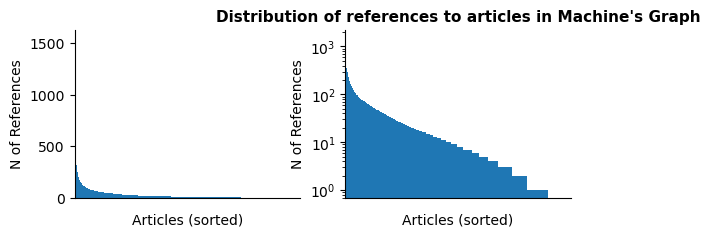

In [29]:
#Distribution of in degrees (number of links pointing to each article)
df_ref_machine=pd.DataFrame(G_links.in_degree, columns=['Article','References'])
df_ref_machine=df_ref_machine.sort_values(by = 'References',ascending = False)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

g=df_ref_machine.plot(ax = ax1,y='References', kind='bar', legend=False, width=1,logy=False)
g.set(ylabel='N of References')
g.set(xlabel='Articles (sorted)')
g.set(xticklabels=[])
g.tick_params(bottom=False);
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

g1=df_ref_machine.plot(ax = ax2, y='References', kind='bar', legend=False, width=1,logy=True)
g1.set(ylabel='N of References')
g1.set(xlabel='Articles (sorted)')
g1.set(xticklabels=[])
g1.tick_params(bottom=False);
g1.spines['right'].set_visible(False)
g1.spines['top'].set_visible(False)

plt.title('Distribution of references to articles in Machine\'s Graph',
                fontsize = 11, fontweight ='bold')
plt.show()

In [31]:
#Number of articles that have zero in-degree
n_non_accessible_links = df_ref_machine.groupby('References').size()[0]
print('Number of articles that have no links to: ',n_non_accessible_links)
print('Percentage: {:.2f}%\n'.format(100*n_non_accessible_links/df_ref_machine.shape[0]))
print('Top 10 articles that have the most links to (highest in-degree): ')
print(df_ref_machine.head(10))

Number of articles that have no links to:  457
Percentage: 9.95%

Top 10 articles that have the most links to (highest in-degree): 
              Article  References
102     United_States        1551
30     United_Kingdom         972
38             France         959
183            Europe         933
31       World_War_II         751
61            England         751
40            Germany         743
115             India         611
54   English_language         598
370            London         587


</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        A similar analysis as before has been done to the players graph. The reason for doing it also on this graph was to see if there are any differences. But it can be seen that both analyzations show a similar distribution that follow the power law. 
       Also in this case some articles have not been accessed.     
    </span>
</div>

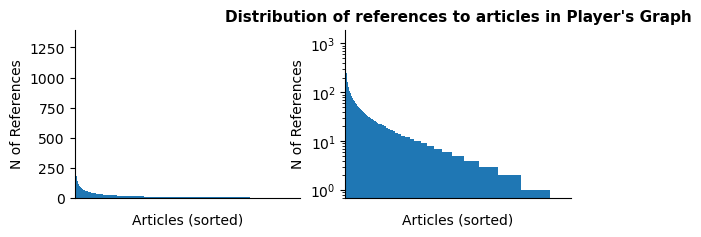

In [33]:
#Distribution of in degrees (number of links pointing to each article)
df_ref_player=pd.DataFrame(G_paths.in_degree, columns=['Article','References'])
df_ref_player=df_ref_player.sort_values(by = 'References',ascending = False)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

g=df_ref_player.plot(ax = ax1,y='References', kind='bar', legend=False, width=1,logy=False)
g.set(ylabel='N of References')
g.set(xlabel='Articles (sorted)')
g.set(xticklabels=[])
g.tick_params(bottom=False);
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

g1=df_ref_player.plot(ax = ax2, y='References', kind='bar', legend=False, width=1,logy=True)
g1.set(ylabel='N of References')
g1.set(xlabel='Articles (sorted)')
g1.set(xticklabels=[])
g1.tick_params(bottom=False);
g1.spines['right'].set_visible(False)
g1.spines['top'].set_visible(False)

plt.title('Distribution of references to articles in Player\'s Graph',
                fontsize = 11, fontweight ='bold')
plt.show()

In [34]:
#Number of articles that have zero in degree
n_never_accessed_links = df_ref_player.groupby('References').size()[0]
print('Number of articles that no players ever accessed from other articles: ',n_non_accessible_links)
print('Percentage: {:.2f}%\n'.format(100*n_non_accessible_links/df_ref_player.shape[0]))

print('Top 10 articles that have the most accessibility in Player\'s Graph: ')
print(df_ref_player.head(10))

Number of articles that no players ever accessed from other articles:  457
Percentage: 10.94%

Top 10 articles that have the most accessibility in Player's Graph: 
              Article  References
98      United_States        1331
70             Europe         741
97     United_Kingdom         710
9             England         618
291      World_War_II         540
10             France         514
11            Germany         396
616  English_language         381
416            Africa         348
13              India         343


</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        <p>Conclusion: In comparison to the biggest hubs list, we found that people tend to access a much more general concept (like 'earth') even though not many links point to that concept. It could be a hint to player's strategy. Deeper analysis is required if we want to have a sound conclusion.<br><br>
        What's more, the difference between the Top 10 Accessibility from Machine's Graph and that from Player's Graph might indicate that player's behaviour is far from random as the numbers are close to each other.</p>
    </span> 
</div>

</div>
<div class="4. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>4. Player statistics</h2>
        <h4>Here we will focus on the level on an individual player</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>4.1 Game distribution per player</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        First we try to see how many games each players finished, <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> or <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">restart</span>. We can then plot the histogram of the percentage of finished games by players. We observe that around $3/4$ of the players either always or never finished their games. This might imply that for these players the game is too easy or too hard and we might addapt the game proposed so that they stay longer.
    </span>
</div>

In [35]:
player_stats = paths_all.groupby('hashedIpAddress').apply(lambda x: pd.Series({
    'game_played' : x['type'].count(),
    'nb_timeout'  : len(x[x['type'] == 'timeout']),    
    'nb_restart'  : len(x[x['type'] == 'restart']),    
    'nb_finished' : len(x[x['type'] == 'finished'])
    }))
player_stats['finished_percentage'] = player_stats['nb_finished']/player_stats['game_played']

Total number of players : 20867,
Player that never finished : 6623,
Player that always finished : 9382


<AxesSubplot:>

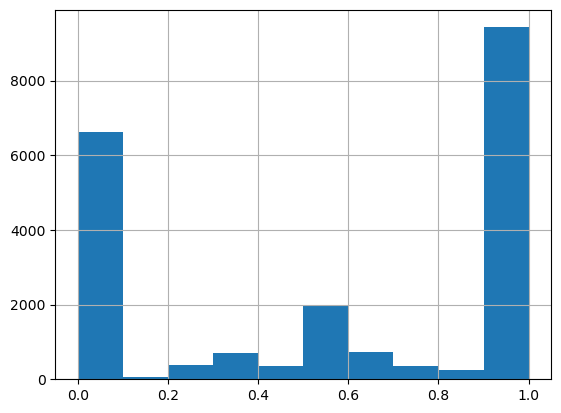

In [37]:
total_player = len(player_stats)
never_finished = len(player_stats[player_stats['nb_finished'] == 0])
always_finished = len(player_stats[player_stats['finished_percentage'] == 1])
print("Total number of players : %d,\nPlayer that never finished : %d,\nPlayer that always finished : %d"%(total_player,never_finished, always_finished))
player_stats.finished_percentage.hist()

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Then we can look, at how many <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> the players did.
    </span>
</div>

Total player that did more than 1 timeout : 634, which represent 0.030383% of the players


<AxesSubplot:>

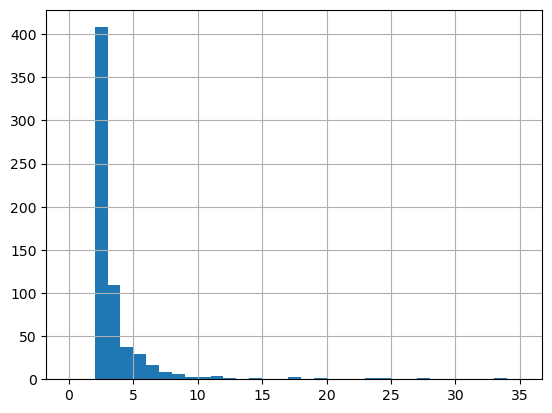

In [41]:
nb_player_mult_timeout = len(player_stats[player_stats.nb_timeout > 1])
print("Total player that did more than 1 timeout : %d, which represent %f%% of the players"%(nb_player_mult_timeout, nb_player_mult_timeout/total_player))
player_stats[player_stats.nb_timeout > 1].nb_timeout.hist(bins = range(0, player_stats.nb_timeout.max()))

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Then we can look at the record of each player on how the game ended up : <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">restart</span>, <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span> or <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">path_finished</span>. We can see that for player than did not finished all their game, 66% of them finished with a <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">timeout</span>.
        What we should do to go deeper is to do the same record but with the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">durationInSec</span> and the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathsLength</span> and try to see if we can get something out of it on why they stopped playing.
    </span>
</div>

In [42]:
players_record = paths_all.sort_values('timestamp').groupby('hashedIpAddress').type.apply(list)
players_record.head(10)

hashedIpAddress
000386124f307de8                      [finished, timeout]
0007183207b6008f           [finished, finished, finished]
000a09e202e88d10                               [finished]
000a5bac5b7781ea                               [finished]
000a6e585b776c96                                [timeout]
000bc9fe5640ed31                     [finished, finished]
000d397013f09039                     [finished, finished]
000e5d4c2c8e921f    [finished, restart, restart, timeout]
000e954305ddb434                               [finished]
0011acb93ed0090b                       [restart, timeout]
Name: type, dtype: object

In [43]:
thresh = 0.99
not_always_finished = len(players_record[player_stats.finished_percentage <= thresh])
end_with_timeout = (players_record[player_stats.finished_percentage <= thresh].apply(lambda x :x[-1] == 'timeout')).sum()
end_with_2_timeouts = (players_record[player_stats.finished_percentage <= thresh].apply(lambda x :x[-1] == 'timeout' and len(x)>=2 and x[-2] == 'timeout')).sum()

print("Number of players that did end with a timeout : %d, which represent %.3f%% of the players that finished less than %.2f of their game"%(end_with_timeout, end_with_timeout/not_always_finished, thresh))
end_with_timeout/not_always_finished

Number of players that did end with a timeout : 7654, which represent 0.666% of the players that finished less than 0.99 of their game


0.6664344797562037

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>4.2 Ratings</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Our idea is to give easier or hardere game to player so that it correspond to their expectations. If they always finish, give them harder game and if they never finish give them easier games. For this we can use rating. We know that 55% of the finished paths were rated.
    </span>
</div>

In [44]:
nb_na_ratings = len(paths_finished[paths_finished.rating.isna()])
total_finished = len(paths_finished)
nb_non_na_ratings = total_finished - nb_na_ratings

print("From the %d finished paths, we have %d that were rated, this corresponds to %.3f of the data"
      %(total_finished, nb_non_na_ratings, nb_non_na_ratings/total_finished))

From the 51318 finished paths, we have 28501 that were rated, this corresponds to 0.555 of the data
